In [1]:
from datetime import datetime
import networkx as nx
Sinceimport numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
sys.path.append('../Results')
from calder_util import *
from multiprocessing import Pool
import dill
import os
from collections import Counter
import seaborn as sns
import scipy
import matplotlib.font_manager
import re

Using compiled interpolation routine
Using compiled sparse grid routine


# Load solutions and compute tree and F error

# TODO: make this function more general (take list of lists and list of labels and just put it together)

In [2]:
#with open("exome3_s.pickle", "rb") as f:
#    calder_s3, calder_s3c, citup_s3, pwgs_s3, pwgs_missing3, citup_missing3 = pickle.load(f)
with open("exome_sim3_groundtruth.pickle", "rb") as f:
    exome_patients3, exome_trees3 = pickle.load(f)

In [8]:
n_instances = 200

# Exome 3 results

In [9]:
calder_s3 = {}
calder_s3c = {}
citup_s3 = {}
pwgs_s3 = {}

pwgs_missing3 = []
citup_missing3 = []

for i in range(200):
    calder_s3[i] = read_calder_soln_nonames("BsimExomeResults/CALDER/exome3_%d/exome3_tree0.txt" % i, exome_patients3[i]['mut_to_idx'])
    desc = get_descendants(calder_s3[i])
    calder_s3[i].F = compute_F(calder_s3[i], desc)
    
    calder_s3c[i] = read_calder_soln_nonames("BsimExomeResults/CALDER/exome3_center_%d/exome3_tree0.txt" % i, exome_patients3
                                             [i]['mut_to_idx'])
    desc = get_descendants(calder_s3c[i])
    calder_s3c[i].F = compute_F(calder_s3c[i], desc)
    
    try:
        citup_s3[i] = read_citup_soln("BsimExomeResults/cluster3/i%d.h5" % i)
        desc = get_descendants(citup_s3[i])
        citup_s3[i].F = compute_F(citup_s3[i], desc)
    except KeyError:
        citup_missing3.append(i)
        
    try:
        pwgs_s3[i] = read_phylowgs_soln("BsimExomeResults/cluster3/pwgs%d" % i, i)
    except FileNotFoundError:
        pwgs_missing3.append(i)
    
with open("exome3_s.pickle", "wb") as f:
    pickle.dump((calder_s3, calder_s3c, citup_s3, pwgs_s3, pwgs_missing3, citup_missing3), f)

In [10]:
with open("exome3_s.pickle", "rb") as f:
    calder_s3, calder_s3c, citup_s3, pwgs_s3, pwgs_missing3, citup_missing3 = pickle.load(f)

In [11]:
len([x for x in range(200) if x not in pwgs_missing3 and x not in citup_missing3])

178

In [12]:
citup_terr3 = []

pe = 0
lc = 0
tl = 0
for i in range(n_instances):
    if i in citup_missing3 or i in pwgs_missing3:
        continue
        
    conf = eval_matrix2(exome_patients3[i], exome_trees3[i], citup_s3[i])
    citup_terr3.append(1 - acc2(conf))
    
    x, y = check_long_conditions(citup_s3[i])
    if triv_long(citup_s3[i]):
        tl += 1
    pe += 1 if x > 0 else 0
    lc += 1 if y > 0 else 0 
pe, lc, tl

(4, 0, 170)

In [13]:
pwgs_terr3 = []
pe = 0
lc = 0
tl = 0
for i in range(n_instances):
    if i in citup_missing3 or i in pwgs_missing3:
        continue
    
    conf = eval_matrix2(exome_patients3[i], exome_trees3[i], pwgs_s3[i])
    pwgs_terr3.append(1 - acc2(conf))
    
    x, y = check_long_conditions(pwgs_s3[i])
    if triv_long(pwgs_s3[i]):
        tl += 1
    pe += x
    lc += y

pe, lc, tl

(0, 0, 178)

In [14]:
calder_terr3 = []
pe = 0
lc = 0
tl = 0
for i in range(n_instances):
    if i in citup_missing3 or i in pwgs_missing3:
        continue
    conf = eval_matrix2(exome_patients3[i], exome_trees3[i], calder_s3[i])
    calder_terr3.append(1 - acc2(conf))
    
    x, y = check_long_conditions(calder_s3[i])
    if triv_long(calder_s3[i]):
        tl += 1
    pe += x
    lc += y
    
    if x > 0 or y > 0:
        print(i, x, y)

pe, lc, tl

(0, 0, 0)

In [15]:
calder_terr3c = []
pe = 0
lc = 0
tl = 0
for i in range(n_instances):
    if i in citup_missing3 or i in pwgs_missing3:
        continue
    conf = eval_matrix2(exome_patients3[i], exome_trees3[i], calder_s3c[i])
    calder_terr3c.append(1 - acc2(conf))
    
    x, y = check_long_conditions(calder_s3c[i])
    if triv_long(calder_s3c[i]):
        tl += 1
    pe += x
    lc += y
    
    if x > 0 or y > 0:
        print(i, x, y)

pe, lc, tl

(0, 0, 0)

In [16]:
print(datetime.now())
with open("sims_exome_10e7_02_001_002_40-justsamples.pickle", "rb") as df:
    exome_sims3 = pickle.load(df)
print(datetime.now())

2019-05-15 20:49:18.595515
2019-05-15 20:49:26.512294


In [17]:
trueFs3 = {}
for i in range(n_instances):
    trueF = {}
    for mut in exome_patients3[i]['mut_labels'].values():
        vec = []
        for t in range(len(exome_sims3[i])):
            if mut in exome_sims3[i][t][1]:
                vec.append(exome_sims3[i][t][1][mut])
            else:
                vec.append(0)
        trueF[mut] = vec
    trueFs3[i] = trueF

In [18]:
calder_ferr3 = []
calder_ferr3c = []
pwgs_ferr3 = []
citup_ferr3 = []

for i in range(n_instances):
    if i in citup_missing3 or i in pwgs_missing3:
        continue
    
    trueF = trueFs3[i]
    calder_ferr3.append(compute_F_distance(calder_s3[i], trueF, exome_patients3[i]['mut_labels']))
    calder_ferr3c.append(compute_F_distance(calder_s3c[i], trueF, exome_patients3[i]['mut_labels']))
    citup_ferr3.append(compute_F_distance(citup_s3[i], trueF, exome_patients3[i]['mut_labels']))
    pwgs_ferr3.append(compute_F_distance(pwgs_s3[i], trueF, exome_patients3[i]['mut_labels']))

In [19]:
w3 = np.zeros((4, len([x for x in range(n_instances) if x not in citup_missing3 and x not in pwgs_missing3])))
idx = 0
for i in range(n_instances):
    if i in citup_missing3 or i in pwgs_missing3:
        continue
    
    trueF = trueFs3[i]
    w3[0][idx] = compute_F_distance(calder_s3[i], trueF, exome_patients3[i]['mut_labels'], binary=True)
    w3[1][idx] = compute_F_distance(calder_s3c[i], trueF, exome_patients3[i]['mut_labels'], binary=True)
    w3[2][idx] = compute_F_distance(citup_s3[i], trueF, exome_patients3[i]['mut_labels'], binary=True)
    w3[3][idx] = compute_F_distance(pwgs_s3[i], trueF, exome_patients3[i]['mut_labels'], binary=True)
    idx += 1


In [20]:
[len(x) for x in w3], len(pwgs_ferr3), len(pwgs_terr3)

([178, 178, 178, 178], 178, 178)

In [21]:
np.mean(citup_terr3), np.median(citup_terr3)

(0.5660401514739469, 0.5512927021178939)

In [22]:
np.mean(pwgs_terr3), np.median(pwgs_terr3)

(0.3484266680490997, 0.3382399014572138)

In [23]:
np.mean(calder_terr3), np.median(calder_terr3)

(0.30915363388275147, 0.2985706882684624)

In [24]:
np.median(w3[0]), np.median(w3[2]), np.median(w3[3])

(0.19893973818024452, 0.2943242828654702, 0.2943242828654702)

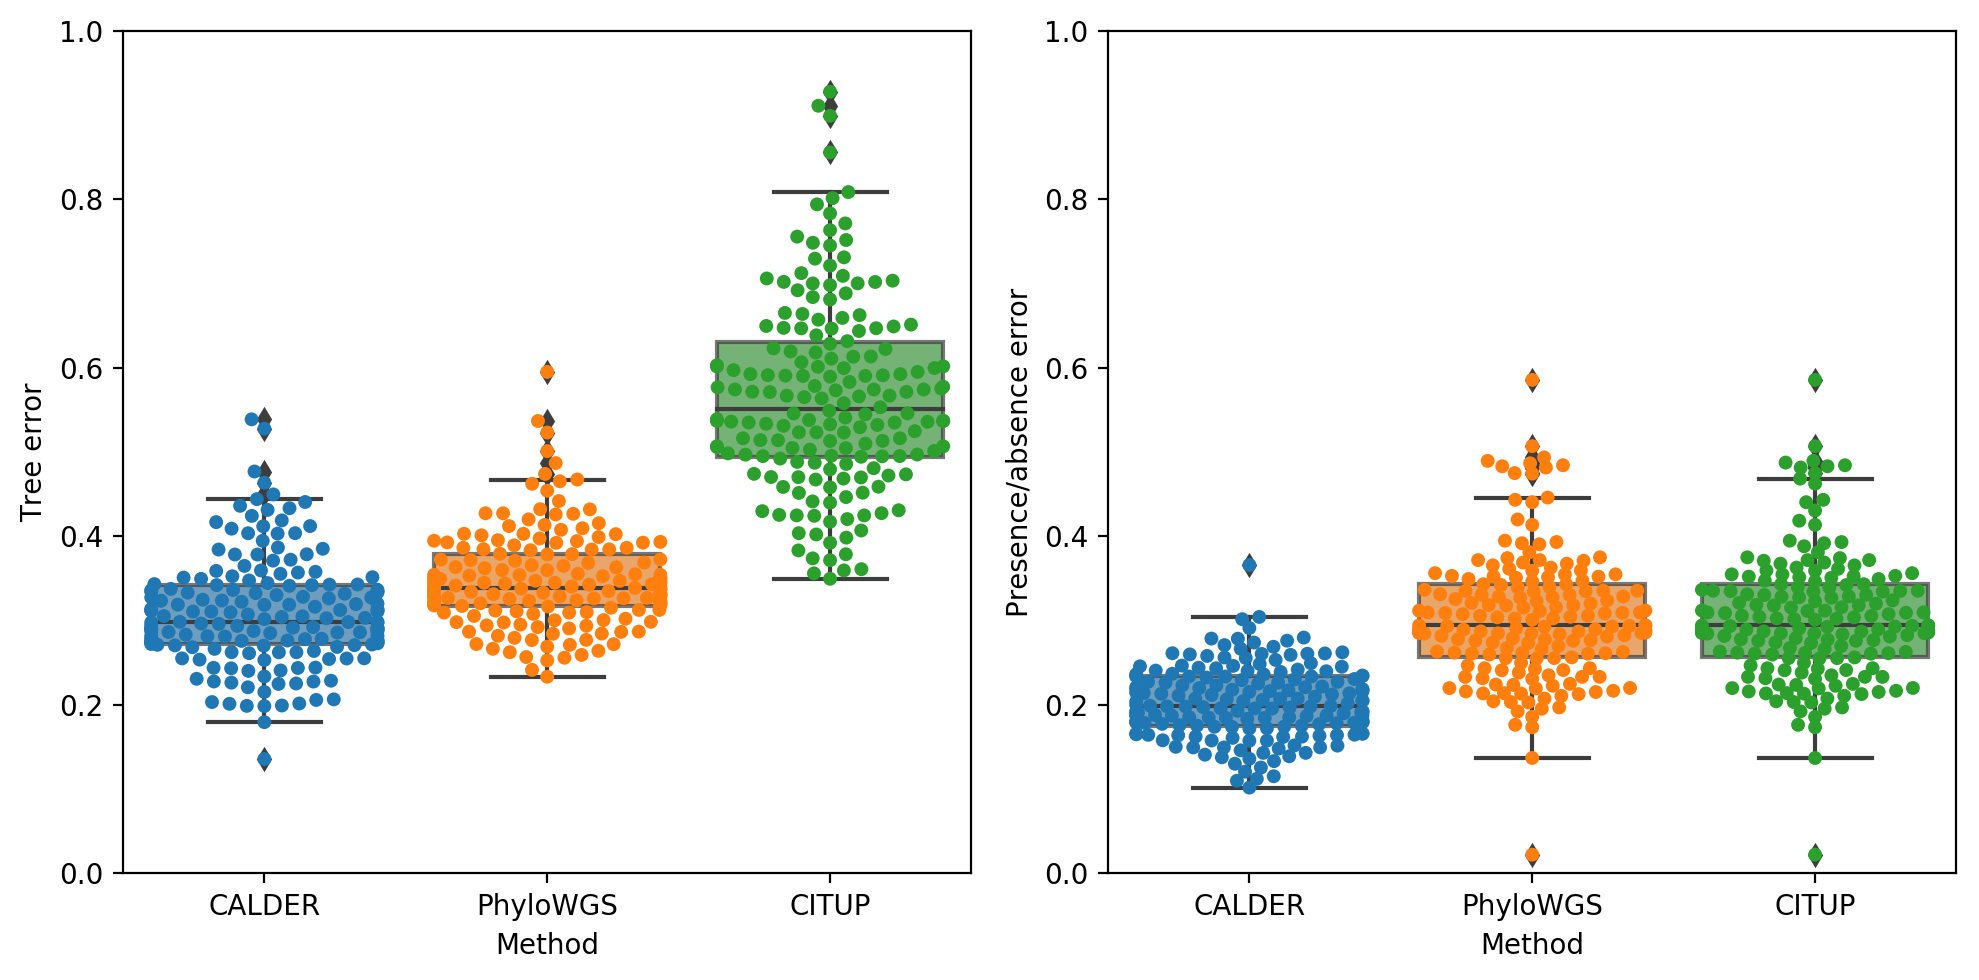

In [25]:
df3 = pd.DataFrame()
df3['citup_tree'] = citup_terr3
df3['calder_tree'] = calder_terr3
df3['pwgs_tree'] = pwgs_terr3
df3['citup_berr'] = w3[2]
df3['calder_berr'] = w3[0]
df3['pwgs_berr'] = w3[3]

q = len([x for x in range(200) if x not in citup_missing3 and x not in pwgs_missing3])

df3_2 = pd.DataFrame()
df3_2['tree'] = pd.concat([df3.calder_tree, df3.pwgs_tree, df3.citup_tree])
df3_2['err2'] = pd.concat([df3.calder_berr, df3.pwgs_berr, df3.citup_berr])
df3_2['method'] = (["CALDER"] * q) + (["PhyloWGS"] * q) + (["CITUP"] * q) 

plt.figure(figsize=(10, 5), dpi=200)
plt.subplot(121)

sns.swarmplot(x="method", y="tree", data=df3_2)
sns.boxplot(x="method", y="tree", data=df3_2, boxprops=dict(alpha=.7))
plt.ylabel("Tree error")
plt.xlabel("Method")
plt.ylim([0, 1])

plt.subplot(122)
sns.swarmplot(x="method", y="err2", data=df3_2)
sns.boxplot(x="method", y="err2", data=df3_2, boxprops=dict(alpha=.7))
plt.ylim([0, 1])
plt.ylabel("Presence/absence error")
plt.xlabel("Method")

plt.tight_layout()
plt.savefig("exome3.png")

Median proportion: 0.700, mean proportion: 0.702
Total number of instances: 423328
99th percentile of total solutions: 1582.00, 95th: 448.00, 90th: 214.00


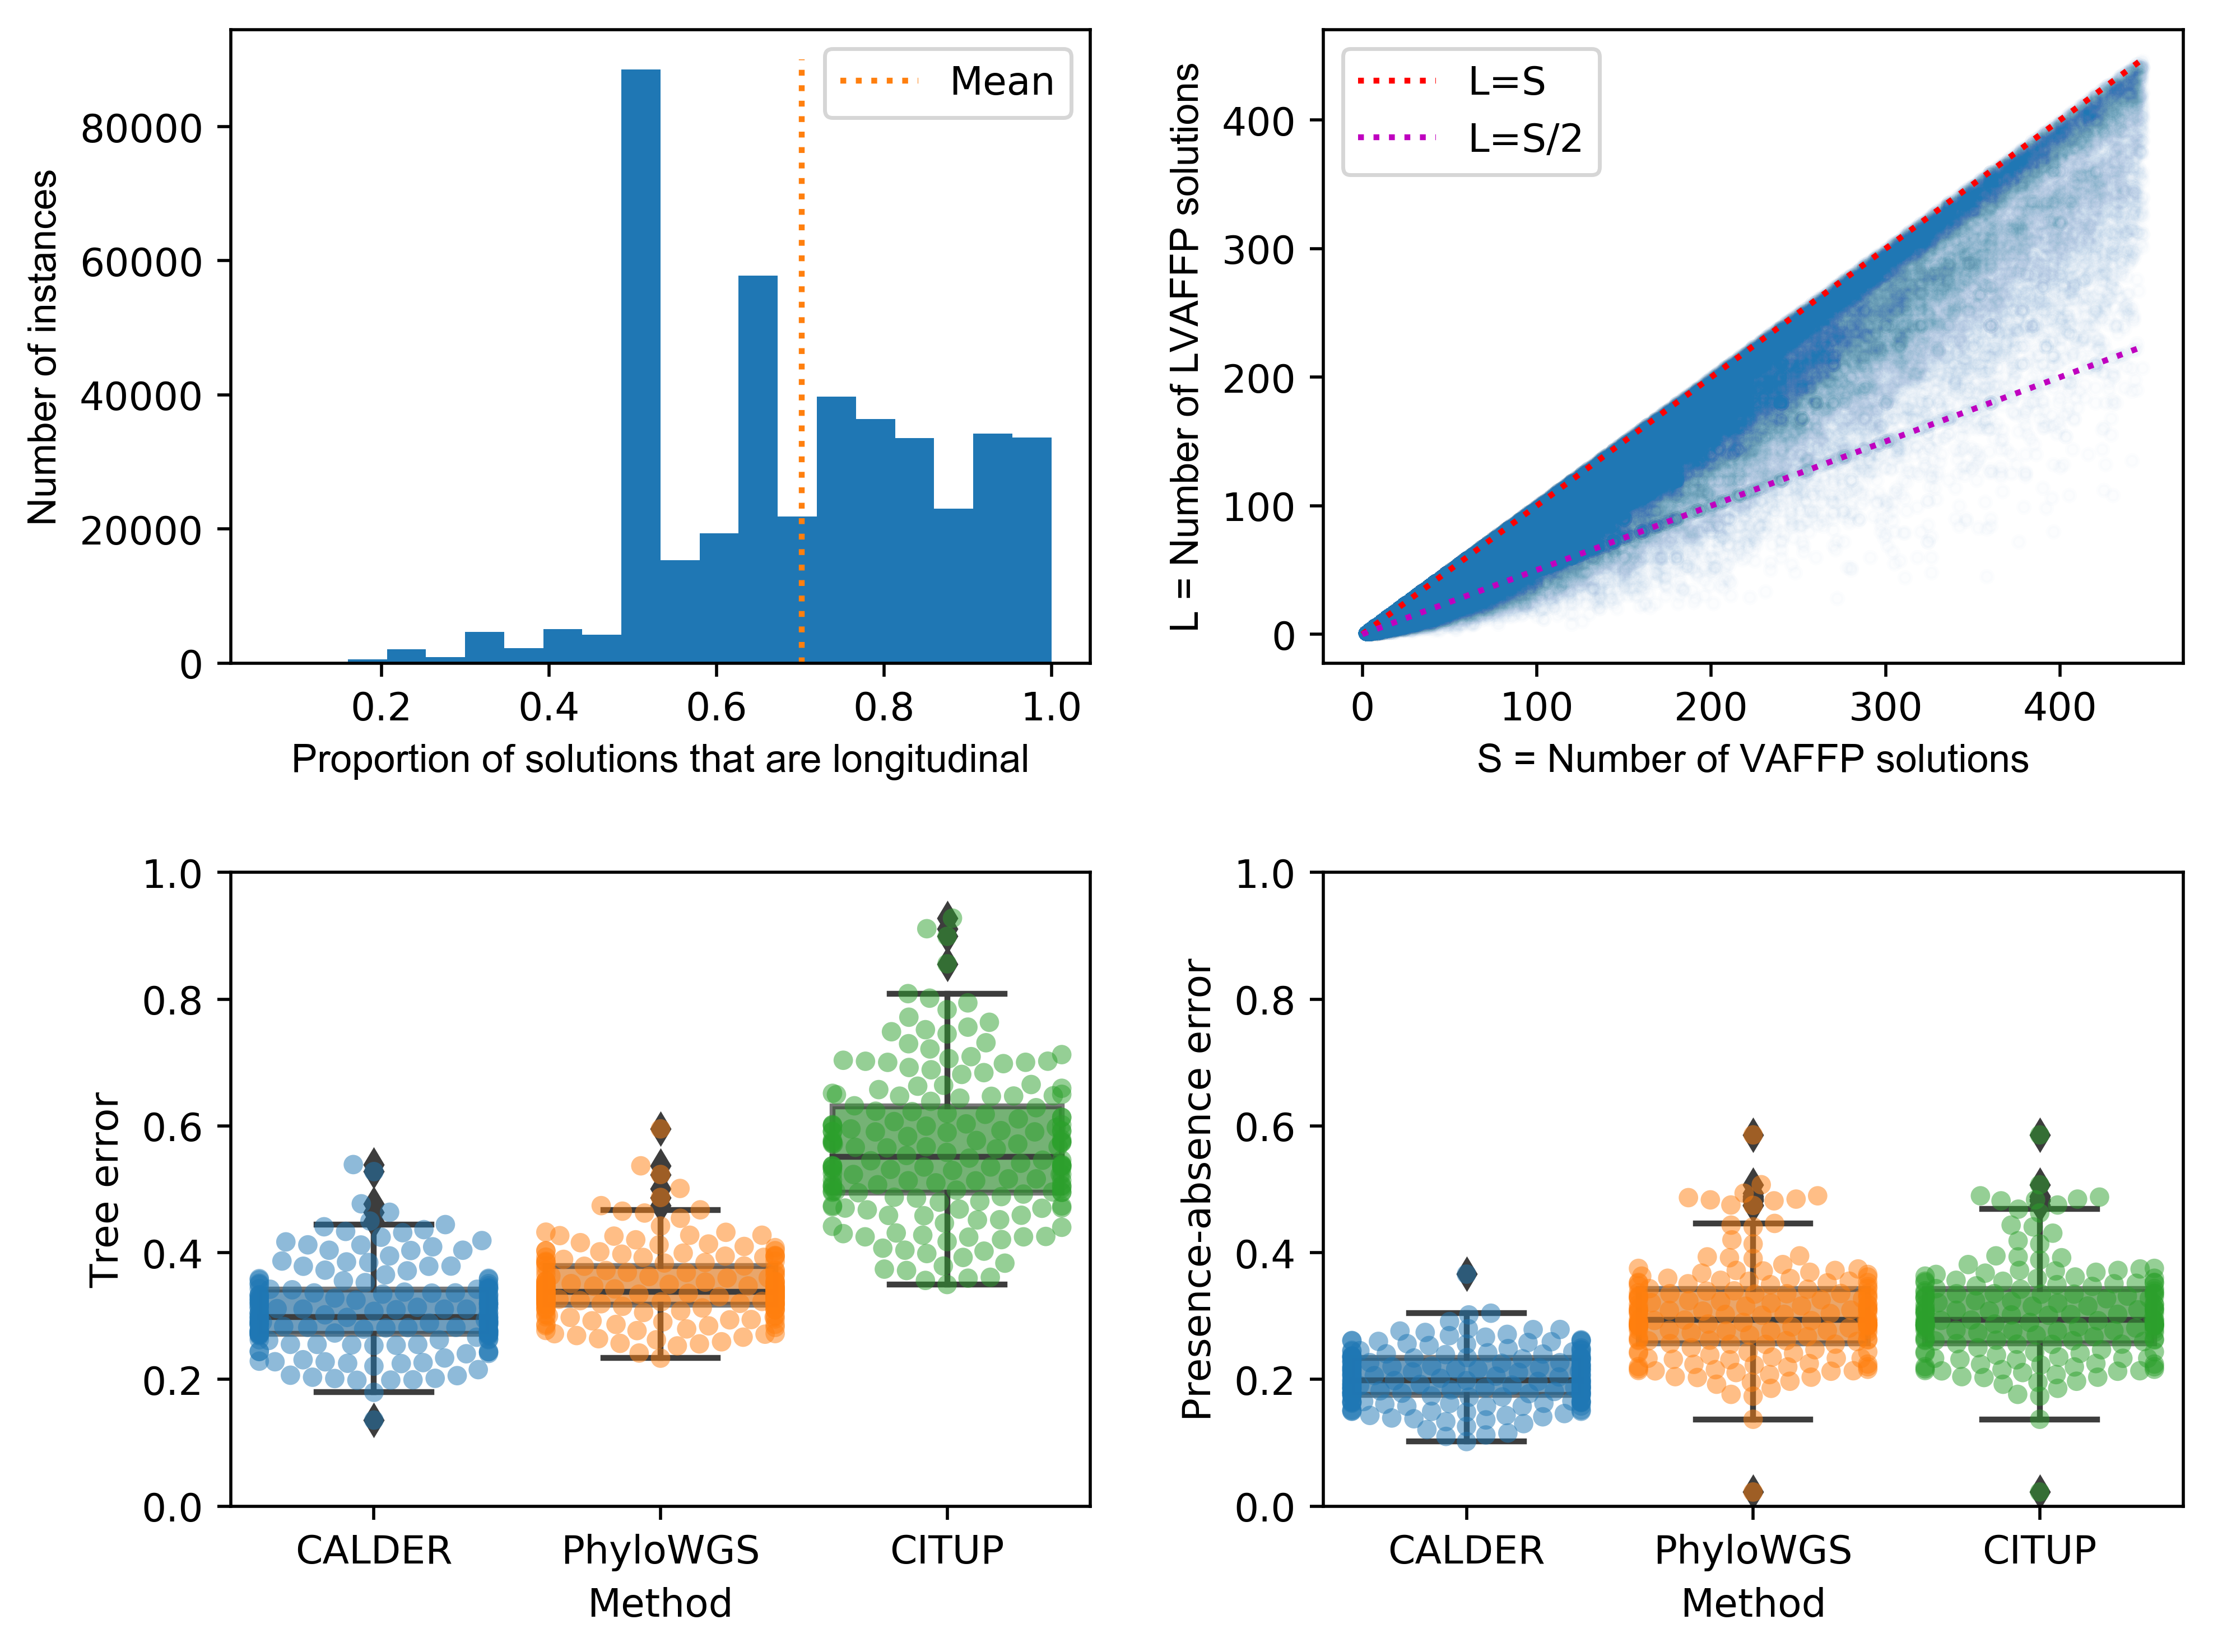

In [26]:
with open("exact-sim-res.pickle", "rb") as f:
    tall, lall, nall, pall = pickle.load(f)
print("Median proportion: %.3f, mean proportion: %.3f" % (np.median(pall), np.mean(pall)))

plt.figure(dpi=500, figsize=(8, 6))

print("Total number of instances: %d" % len(tall))
arr = np.array(tall)
per95 = np.percentile(tall, 95)
per90 = np.percentile(tall, 90)
print("99th percentile of total solutions: %.2f, 95th: %.2f, 90th: %.2f" % (np.percentile(tall, 99), per95, per90))
low_idx = [i for i in range(len(tall)) if tall[i] < per95]
totals = np.array(tall)
longs = np.array(lall)
prop = np.array(pall)
nsamples = np.array(len(tall))

plt.subplot(221)
plt.hist(prop, bins=20)
plt.xlabel("Proportion of solutions that are longitudinal", fontname='Arial')
med = np.median(prop)
mean = np.mean(prop)
plt.plot([mean, mean], [0, 90000], linestyle=":")
#plt.plot([med, med], [0, 90000], linestyle=":")
plt.legend(["Mean"])
plt.ylabel("Number of instances", fontname='Arial')

plt.subplot(222)
# Rather than plotting every point, stack points and adjust their alpha values (reduces about 5x)
mylist = []
for i in range(len(tall)):
    mylist.append((tall[i], lall[i], nall[i], pall[i]))
mc = Counter(mylist).most_common()
alphas = [min(1, x[1] / 100) for x in mc]

my_colors = np.zeros((len(mc), 4))
my_colors[:,2] = 1.0
my_colors[:,3] = alphas
plt.scatter(totals[low_idx], longs[low_idx], alpha=.01, marker='.')
plt.plot([0, per95], [0,per95], 'r:')
plt.plot([0, per95], [0,per95 / 2], 'm:')
plt.legend(["L=S", "L=S/2"])


plt.xlabel("S = Number of VAFFP solutions", fontname='Arial')
plt.ylabel("L = Number of LVAFFP solutions", fontname='Arial')

plt.subplot(223)
sns.swarmplot(x="method", y="tree", data=df3_2, alpha=0.5)
sns.boxplot(x="method", y="tree", data=df3_2, boxprops=dict(alpha=.7))
plt.ylabel("Tree error")
plt.xlabel("Method")
plt.ylim([0, 1])

plt.subplot(224)
sns.swarmplot(x="method", y="err2", data=df3_2, alpha=0.5)
sns.boxplot(x="method", y="err2", data=df3_2, boxprops=dict(alpha=.7))
plt.ylim([0, 1])
plt.ylabel("Presence-absence error")
plt.xlabel("Method")

plt.tight_layout( w_pad=2, h_pad=2)
plt.savefig("allsim-branch.png")

(array([ 7., 12., 47., 53., 41., 21.,  9.,  4.,  4.,  2.]),
 array([ 65. ,  81.9,  98.8, 115.7, 132.6, 149.5, 166.4, 183.3, 200.2,
        217.1, 234. ]),
 <a list of 10 Patch objects>)

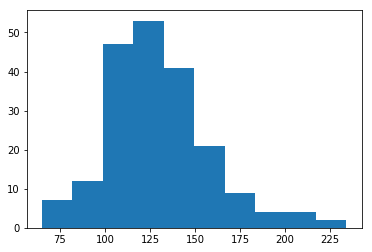

In [27]:
plt.hist([x['n'] for x in exome_patients3])

In [29]:
muts = [exome_patients3[i]['n'] for i in range(200) if i not in citup_missing3 and i not in pwgs_missing3]
sam = [exome_patients3[i]['m'] for i in range(200) if i not in citup_missing3 and i not in pwgs_missing3]
np.min(muts), np.max(muts), np.mean(muts), np.median(muts)

(65, 234, 127.71348314606742, 122.5)

In [30]:
np.min(sam), np.max(sam), np.mean(sam)

(2, 5, 4.98314606741573)

In [31]:
all_depths = []
for i in range(200):
    if i in citup_missing3 or i in pwgs_missing3:
        continue
    x = exome_patients3[i]
    for t in range(x['m']):
        for j in range(x['n']):
            all_depths.append(sum(x['data'][t, j]))
np.mean(all_depths), np.median(all_depths)

(199.94937010795624, 200.0)

In [32]:
scipy.stats.wilcoxon(calder_terr3, pwgs_terr3), scipy.stats.wilcoxon(pwgs_terr3, citup_terr3), scipy.stats.wilcoxon(calder_terr3, citup_terr3)

(WilcoxonResult(statistic=3364.0, pvalue=2.325561298292456e-11),
 WilcoxonResult(statistic=32.0, pvalue=9.997042646459127e-31),
 WilcoxonResult(statistic=3.0, pvalue=6.124941666292956e-31))

In [33]:
scipy.stats.wilcoxon(w3[0], w3[3]), scipy.stats.wilcoxon(w3[3], w3[2]), scipy.stats.wilcoxon(w3[0], w3[2])

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


(WilcoxonResult(statistic=320.0, pvalue=1.770105223278962e-28),
 WilcoxonResult(statistic=5.0, pvalue=0.0687035743228782),
 WilcoxonResult(statistic=308.0, pvalue=2.183083431229981e-28))

In [34]:
[1 for x in exome_patients3 if x['m'] == 1]

[]

In [35]:
citup_missing3

[78, 142, 149, 169, 172]

# Compare clustering

In [36]:
all_clusters = []
good_i = {}
for i in range(200):
    try:
        clusters = read_clusters("BsimExomeResults/pyclone/cluster_assignments/exome3_%d.txt/cluster_assignments.txt" % i)
    except Exception:
        print("Missing instance", i)
        continue
    good_i[i] = True
    all_clusters.append(clusters)
    p = exome_patients3[i]
    p['mut_to_idx'] = {str(k):v for k,v in p['mut_to_idx'].items()}
    write_CALDER_cl_labels(p, clusters, "BranchingSimData/exome3/CALDER-pyclone/exome3_%d.txt" % i)

Missing instance 10
Missing instance 12
Missing instance 13
Missing instance 16
Missing instance 101
Missing instance 103
Missing instance 104
Missing instance 106
Missing instance 111
Missing instance 112
Missing instance 115
Missing instance 117
Missing instance 120
Missing instance 122
Missing instance 124
Missing instance 125
Missing instance 127
Missing instance 129
Missing instance 130
Missing instance 131
Missing instance 133
Missing instance 134
Missing instance 135
Missing instance 138
Missing instance 145
Missing instance 159
Missing instance 160
Missing instance 171


In [37]:
len(good_i), len([i for i in good_i.keys() if i not in citup_missing3 and i not in pwgs_missing3])

(172, 151)

In [38]:
# construct clustering frequency matrices
pycl = {}
for i in good_i.keys():
    clusters = read_clusters("BsimExomeResults/pyclone/cluster_assignments/exome3_%d.txt/cluster_assignments.txt" % i)
    pycl[i] = write_CALDER_cl_labels(exome_patients3[i], clusters, "junk"), clusters

py_freqs = {}
for i, (data, mapping) in pycl.items():
    py_f = {}
    idx_to_mut = exome_patients3[i]['mut_labels']
    for p in range(len(mapping)):
        vec = []
        for t in range(exome_patients3[i]['m']):
            datum = data[t, p]
            vec.append((datum[1] / sum(datum), sum(datum)))
            
        for mut in mapping[p]:
            py_f[int(mut)] = vec
    py_freqs[i] = py_f
    
    
cl_data = {}
for i in good_i.keys():
    clusters = read_clusters("../shared_folder/clustering_output/exome3_%d/cluster_assignments.txt" % i)
    cl_data[i] = write_CALDER_cl_labels(exome_patients3[i], clusters, 'junk'), clusters

cl_freqs = {}
for i, (data, mapping) in cl_data.items():
    cl_f = {}
    idx_to_mut = exome_patients3[i]['mut_labels']
    for p in range(len(mapping)):
        vec = []
        for t in range(exome_patients3[i]['m']):
            datum = data[t, p]
            vec.append((datum[1] / sum(datum), sum(datum)))
            
        for mut in mapping[p]:
            cl_f[int(mut)] = vec
    cl_freqs[i] = cl_f

In [39]:
calder_pycl = {}
for i in good_i.keys():
    calder_pycl[i] = read_calder_soln_nonames("BsimExomeResults/CALDER-pyclone/exome3_%d/exome3_tree0.txt" % i, {int(k):v for k, v in exome_patients3[i]['mut_to_idx'].items()})
    desc = get_descendants(calder_pycl[i])
    calder_pycl[i].F = compute_F(calder_pycl[i], desc)    

# New trees and new tree metrics

In [40]:
def get_real_tree(ng, patient):
    muts = patient['mut_labels'].values()
    tree = {}
    lineages = []
    for mut in muts:
        my_geno = [x for x in ng if x[-1] == mut]
        assert len(my_geno) == 1
        my_geno = my_geno[0]
        lineages.append([x for x in my_geno if x in patient['mut_to_idx'] or str(x) in patient['mut_to_idx']])
        print(lineages[-1])
    for lineage in lineages:
        for i in range(len(lineage) - 1):
            curr = lineage[i]
            next = lineage[i + 1]
            if curr in tree:
                if next not in tree[curr]:
                    tree[curr].append(next)
            else:
                tree[curr] = [next]
    return tree

In [42]:
with open("real_trees3.pickle", "rb") as f:
    real_trees = pickle.load(f)

In [124]:
def get_clones(trueF, tree):
    clones = {}
    for mut, freqs in trueF.items():
        if tuple(freqs) in clones:
            clones[tuple(freqs)].append(mut)
        else:
            clones[tuple(freqs)] = [mut]
    
    # make sure that clones are consecutive in the tree
    to_dissolve = {}
    for vec, muts in clones.items():
        lineage = sorted(muts)
        for i in range(len(lineage) - 1):
            curr = lineage[i]
            next = lineage[i + 1]
            if not (curr in tree) or next not in tree[curr]:
                # the mutations in this cluster are not actually related
                to_dissolve[vec] = True
                break
            assert next in tree[curr]
    
    id_to_vec = {}
    clusters = {}
    i = 0

    desc = {}
    for vec in to_dissolve.keys():
        i += 1
        muts = clones[vec]
        del clones[vec]
        
        #print(muts)
        if len(muts) == 2:
            for mut in muts:
                id_to_vec[i] = vec
                clusters[mut] = i
                i += 1 
        else:
            # have to actually check lineages to see if there are ancestral relationships
            # sort so that we check earliest ancestor of each lineage first
            my_muts = sorted(muts.copy())
            curr = 0
            while curr < len(my_muts):
                mut = my_muts[curr]
                my_group = [mut]
                
                # find my descendants
                if mut in desc:
                    my_desc = desc[mut]
                else:
                    my_desc = {}
                    if mut in tree:
                        next = tree[mut].copy()
                        while len(next) > 0:
                            v = next.pop()
                            my_desc[v] = True
                            if v in tree:
                                next.extend(tree[v])
                    desc[mut] = my_desc
                
                # check to see if others are my descendants
                my_group.extend([other for other in my_muts[curr + 1:] if other in my_desc])
                
                # if so, remove them from the list
                for other in my_group[1:]:
                    my_muts.remove(other)
                    
                # add my_group to the cluster outputs
                for mymut in my_group:
                    clusters[mymut] = i
                id_to_vec[i] = vec
                    
                i += 1
                curr += 1

    for vec, muts in clones.items():
        i += 1
        for mut in muts:
            clusters[mut] = i
        id_to_vec[i] = vec
    return clusters, id_to_vec

In [69]:
def writeTrueFToFile(F, filename):
    non0_vecs = {}
    for mut, vec in F.items():
        if any(x for x in vec if x > 0):
            non0_vecs[mut] = vec
    t = len(F[0])
    rows = []
    rows.append(["mut_IDs:"])
    for my_t in range(t):
        rows.append(["Sample%d" % my_t])
    for mut, vec in non0_vecs.items():
        rows[0].append(mut)
        for my_t in range(t):
            rows[my_t + 1].append(vec[my_t])
    with open(filename, "w") as f:
        for row in rows:
            f.write(",".join([str(x) for x in row]))
            f.write("\n")
        

In [126]:
gt_clustering = {}
id_to_vec = {}
for idx in range(n_instances):
    print(idx)
    gt_clustering[idx], id_to_vec[idx] = get_clones(trueFs3[idx], real_trees[idx])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [ ]:
trueUs = {}
for i in trueFs3.keys():
    myU = {}
    for mut, freq in trueFs3[i].items():
        vec = freq.copy()
        children = [0 for x in vec]
        if mut in real_trees[i]:
            for child in real_trees[i][mut]:
                if child in trueFs3[i]:
                    for t in range(len(vec)):
                        children[t] += trueFs3[i][child][t]
        #print(mut, vec, children)
        for t in range(len(vec)):
            vec[t] -= children[t]
            assert vec[t] >=0 and vec[t] <= 1 or np.abs(vec[t]) < scipy.power(10, -8)
        myU[mut] = vec
    trueUs[i] = myU


In [ ]:
def heatU(myU):
    umatrix = []
    for mut, vec in myU.items():
        if not all(x == 0 for x in vec):
            umatrix.append(vec)
    cg =  sns.clustermap(pd.DataFrame(umatrix).transpose(), row_cluster=False, cmap="viridis")
    cg.ax_col_dendrogram.set_visible(False)
    return cg

130


Text(0.5, 0, 'Cluster size')

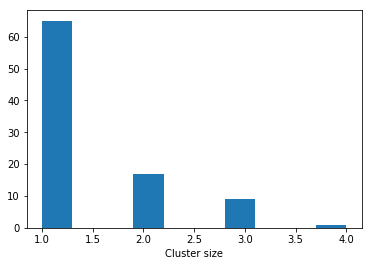

In [139]:
clones = {}
print(len(trueFs3[99]))
for mut, freqs in trueFs3[99].items():
    if tuple(freqs) in clones:
        clones[tuple(freqs)].append(mut)
    else:
        clones[tuple(freqs)] = [mut]
plt.hist([len(x) for x in clones.values()])
plt.xlabel("Cluster size")

Text(0.5, 0, 'Cluster size')

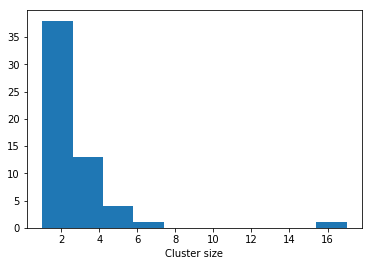

In [140]:
clones = {}
for mut, freqs in trueFs3[99].items():
    if freqs[-1] in clones:
        clones[freqs[-1]].append(mut)
    else:
        clones[freqs[-1]] = [mut]
plt.hist([len(x) for x in clones.values()])
plt.xlabel("Cluster size")

In [103]:
def eval_matrix4x4(gt_patient, gt_tree, gt_clust, solution):
    """
    Construct confusion matrix using parameter ground-truth simulation instance and parameter Solution object
    Rows indicate ground truth relationship: i->j, j->i, or i and j are unrelated, respectively
    Columns indiate solution relationship: i->j, j->i, i and j in the same cluster, or i and j are unrelated
    """
    # Construct ground truth ancestry object (TODO: do this once for each instance)
    true_n = gt_patient['n']
    gt_ancestral = {}
    for anc in gt_tree.keys():
        desc = {}
        to_visit = list(gt_tree[anc]) # make a copy of the children of anc in the tree
        while len(to_visit) > 0:
            curr = to_visit.pop()
            desc[curr] = True
            if curr in gt_tree:
                to_visit.extend(list(gt_tree[curr]))
        gt_ancestral[anc] = desc
        
    # Create mapping from mutation names to mutation indices
    if solution.uses_names:
        # CALDER uses mutation names internally, so this mapping is simple
        labels = {}
        for x in gt_patient['mut_labels'].values():
            labels[int(x)] = int(x)
    else:
        # Other methods use mutation indices internally, which need to be decoded
        labels = gt_patient['mut_labels']
            
    # Construct ancestry object from solution (NOTE: this function produces a tree on clusters)
    s_ancestral = get_descendants(solution)
    
    # Expand clusters into individual mutations
    real_s_ancestral = {}
    for anc_cl, desc_cls in s_ancestral.items():
        new_desc = {}
        for desc_cl in desc_cls:
            for d_mut in solution.id_to_muts[desc_cl]:
                new_desc[int(labels[int(d_mut)])] = True
        for a_mut in solution.id_to_muts[anc_cl]:
            real_s_ancestral[int(labels[int(a_mut)])] = new_desc
    s_ancestral = real_s_ancestral
    s_pairs = {}

    # for pair (a,b), 0 = a precedes b, 1 = b precedes a, 2 = clustered together, 3 = incomparable
    # row = ground truth, column = predicted
    
    missing_muts = {}
    
    count = 0
    conf = np.zeros((4,4)).astype(int)
    for idx in range(true_n):
        for jdx in range(idx):        
            count += 1
            i = int(gt_patient['mut_labels'][idx])
            j = int(gt_patient['mut_labels'][jdx])
            
            assert not ((i in gt_ancestral and j in gt_ancestral[i]) and (j in gt_ancestral and i in gt_ancestral[j]))

            
            # check ground truth clustering first because gt_tree is fully resolved
            if gt_clust[i] == gt_clust[j]:
                gt = 2
            elif i in gt_ancestral and j in gt_ancestral[i]:
                gt = 0
            elif j in gt_ancestral and i in gt_ancestral[j]:
                gt = 1
            else:
                if i == 0 and j == 1:
                    print(gt_clust[i], gt_clust[j])
                gt = 3
                
            
            assert not ((i in s_ancestral and j in s_ancestral[i]) and (j in s_ancestral and i in s_ancestral[j]))

            if i in s_ancestral and j in s_ancestral[i]:
                pred = 0
            elif j in s_ancestral and i in s_ancestral[j]:
                pred = 1
            elif solution.mut_to_cluster[idx] == solution.mut_to_cluster[jdx]:
                pred = 2
            else:
                pred = 3            
            
            conf[gt][pred] += 1
            
            s_pairs[(i,j)] = pred
            if (j,i) in s_pairs and s_pairs[j,i] != 2:
                assert pred == 1 - s_pairs[j,i]
    return conf


In [109]:
def acc4(conf):
    return sum([conf[i][i] for i in range(4)]) / sum(sum(conf))

In [110]:
c = eval_matrix4x4(exome_patients3[0], real_trees[0], gt_clustering[0], calder_s3[0])
acc4(c)

0.6881008525303828

In [115]:
gt_clustering[44]

{8943: 1,
 9139: 2,
 0: 4,
 236: 5,
 1303: 5,
 769: 6,
 1946: 6,
 977: 7,
 3202: 8,
 4389: 8,
 6159: 8,
 3787: 9,
 3978: 10,
 4452: 11,
 4664: 12,
 4761: 13,
 6048: 14,
 6342: 15,
 6455: 15,
 6357: 16,
 7057: 16,
 8484: 16,
 6565: 17,
 8079: 18,
 8475: 19,
 9236: 19,
 8805: 20,
 9371: 21,
 9494: 22,
 9916: 23,
 10296: 24,
 10663: 25,
 11536: 26,
 11553: 27,
 11780: 28,
 12007: 29,
 14502: 30,
 14713: 31,
 15132: 32,
 13652: 33,
 13860: 34,
 15018: 35,
 15756: 35,
 16920: 36,
 17115: 37,
 17151: 38,
 17417: 39,
 19776: 40,
 20651: 41,
 22755: 42,
 23157: 43,
 25120: 43,
 23592: 44,
 24298: 45,
 24625: 46,
 25527: 47,
 28147: 48,
 12574: 49,
 16597: 49,
 14463: 50,
 20365: 51,
 20840: 51,
 20635: 52,
 21156: 53,
 22135: 54,
 22302: 55,
 22305: 56,
 22745: 57,
 24019: 58,
 25874: 58,
 28119: 59,
 28396: 60,
 30259: 60,
 28500: 61,
 30631: 62,
 33985: 63,
 35363: 64,
 36497: 65,
 37154: 66,
 37492: 67,
 38722: 68,
 41039: 69,
 42450: 69,
 44175: 70,
 48994: 71,
 51199: 72,
 52915: 72,
 168

In [128]:
citup_t4 = []

pe = 0
lc = 0
tl = 0
for i in range(n_instances):
    if i in citup_missing3 or i in pwgs_missing3:
        continue
        
    conf = eval_matrix4x4(exome_patients3[i], real_trees[i], gt_clustering[i], citup_s3[i])
    citup_t4.append(1 - acc4(conf))
    
    x, y = check_long_conditions(citup_s3[i])
    if triv_long(citup_s3[i]):
        tl += 1
    pe += 1 if x > 0 else 0
    lc += 1 if y > 0 else 0 
pe, lc, tl

(4, 0, 170)

In [129]:
pwgs_t4 = []

pe = 0
lc = 0
tl = 0
for i in range(n_instances):
    if i in citup_missing3 or i in pwgs_missing3:
        continue
        
    conf = eval_matrix4x4(exome_patients3[i], real_trees[i], gt_clustering[i], pwgs_s3[i])
    pwgs_t4.append(1 - acc4(conf))
    
    x, y = check_long_conditions(pwgs_s3[i])
    if triv_long(pwgs_s3[i]):
        tl += 1
    pe += 1 if x > 0 else 0
    lc += 1 if y > 0 else 0 
pe, lc, tl

(0, 0, 178)

In [130]:
calder_t4 = []

pe = 0
lc = 0
tl = 0
for i in range(n_instances):
    if i in citup_missing3 or i in pwgs_missing3:
        continue
        
    conf = eval_matrix4x4(exome_patients3[i], real_trees[i], gt_clustering[i], calder_s3[i])
    calder_t4.append(1 - acc4(conf))
    
    x, y = check_long_conditions(calder_s3[i])
    if triv_long(calder_s3[i]):
        tl += 1
    pe += 1 if x > 0 else 0
    lc += 1 if y > 0 else 0 
pe, lc, tl

(0, 0, 0)

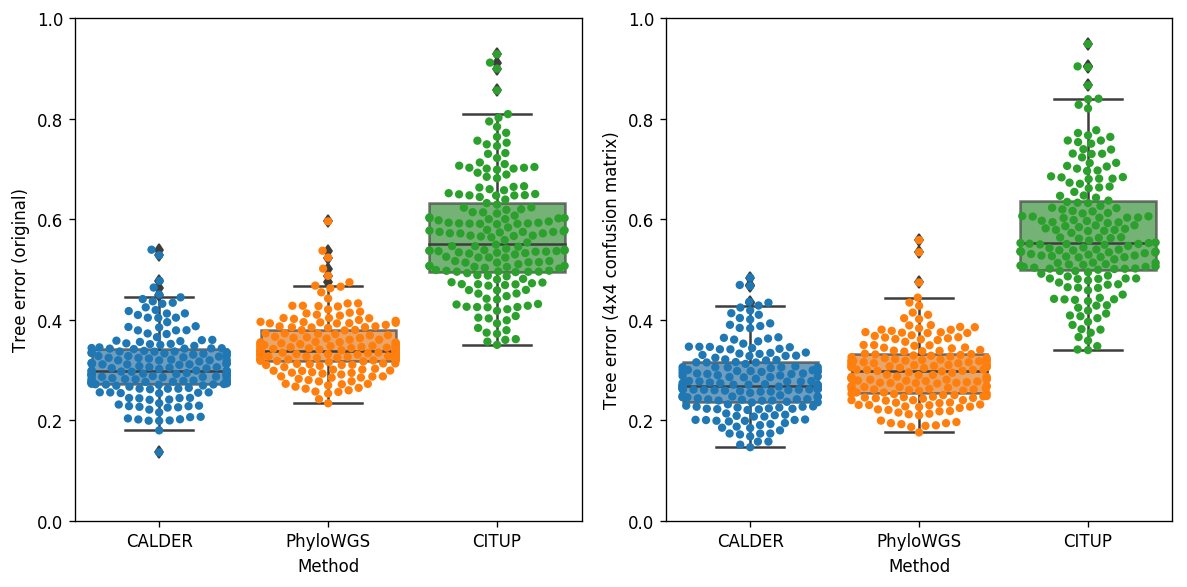

In [137]:
df4 = pd.DataFrame()
df4['citup_tree'] = citup_t4
df4['calder_tree'] = calder_t4
df4['pwgs_tree'] = pwgs_t4

q = len([x for x in range(200) if x not in citup_missing3 and x not in pwgs_missing3])

df4_2 = pd.DataFrame()
df4_2['tree'] = pd.concat([df4.calder_tree, df4.pwgs_tree, df4.citup_tree])
df4_2['method'] = (["CALDER"] * q) + (["PhyloWGS"] * q) + (["CITUP"] * q) 

plt.figure(figsize=(10, 5), dpi=120)
plt.subplot(121)
sns.swarmplot(x="method", y="tree", data=df3_2)
sns.boxplot(x="method", y="tree", data=df3_2, boxprops=dict(alpha=.7))
plt.ylabel("Tree error (original)")
plt.xlabel("Method")
plt.ylim([0, 1])

plt.subplot(122)
sns.swarmplot(x="method", y="tree", data=df4_2)
sns.boxplot(x="method", y="tree", data=df4_2, boxprops=dict(alpha=.7))
plt.ylabel("Tree error (4x4 confusion matrix)")
plt.xlabel("Method")
plt.ylim([0, 1])


plt.tight_layout()
plt.savefig("exome3-newtreemetric.png")

Median proportion: 0.700, mean proportion: 0.702
Total number of instances: 423328
99th percentile of total solutions: 1582.00, 95th: 448.00, 90th: 214.00


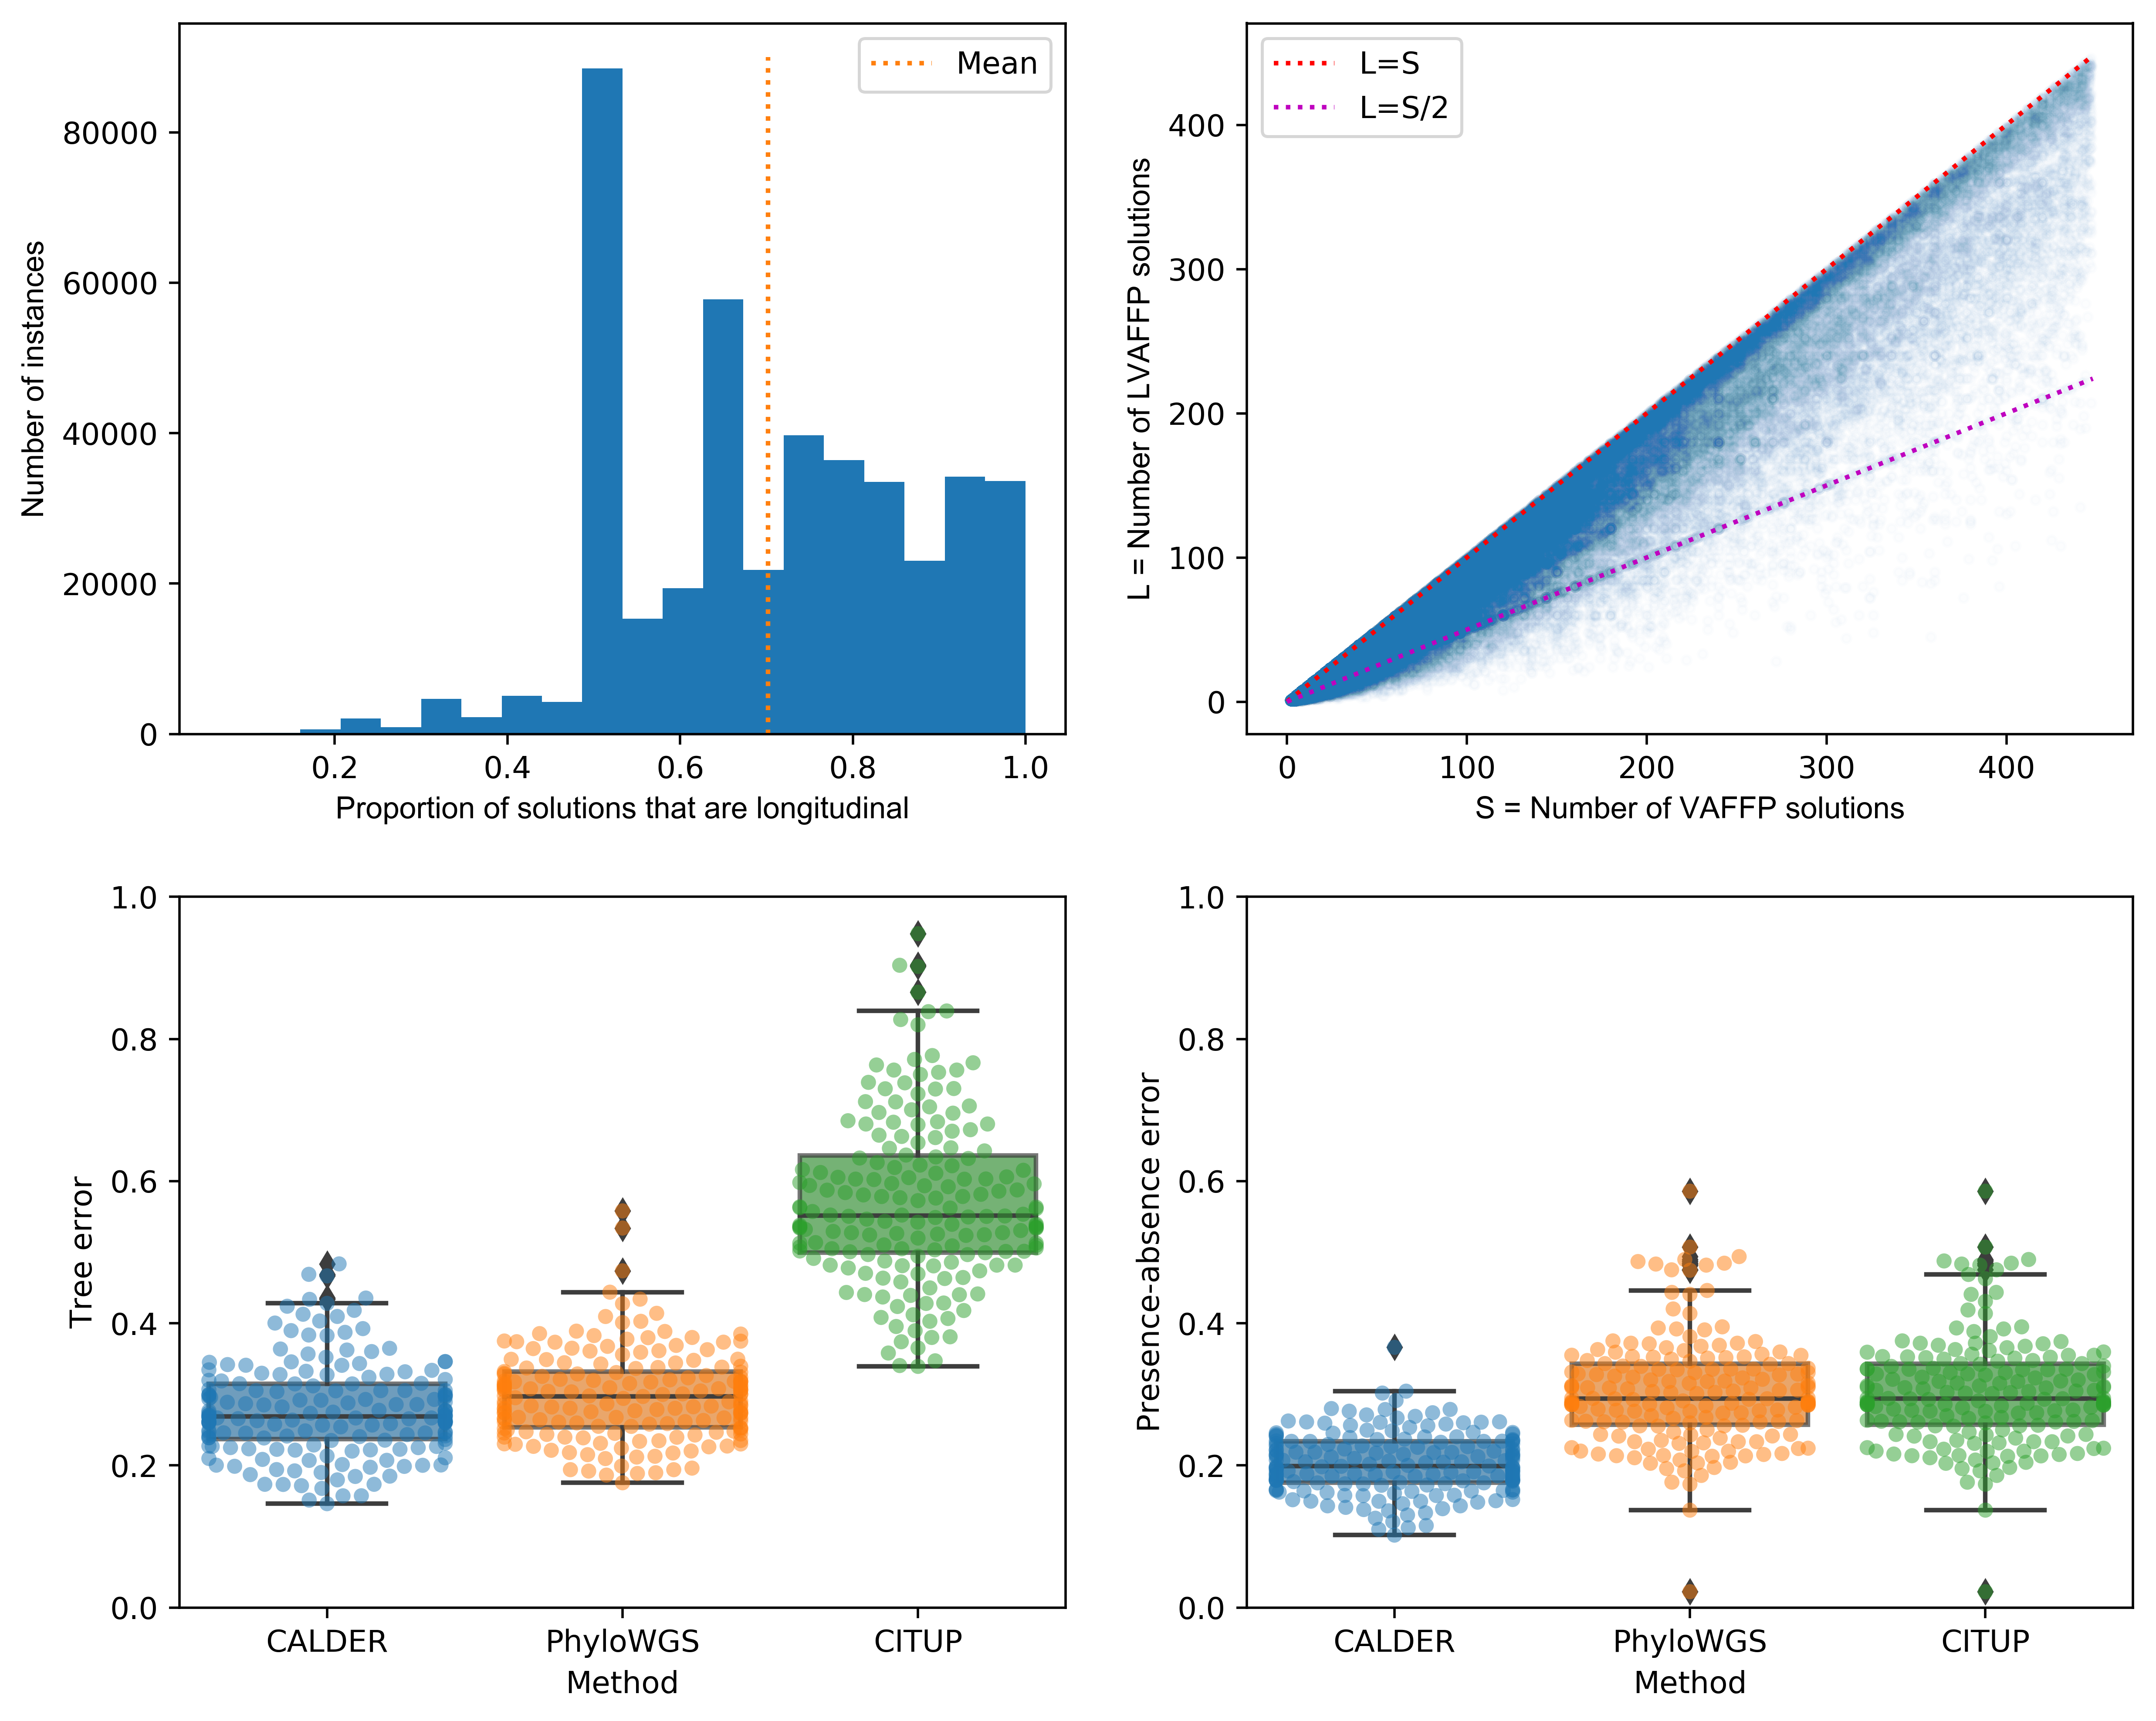

In [145]:
with open("exact-sim-res.pickle", "rb") as f:
    tall, lall, nall, pall = pickle.load(f)
print("Median proportion: %.3f, mean proportion: %.3f" % (np.median(pall), np.mean(pall)))

plt.figure(dpi=500, figsize=(10, 8))

print("Total number of instances: %d" % len(tall))
arr = np.array(tall)
per95 = np.percentile(tall, 95)
per90 = np.percentile(tall, 90)
print("99th percentile of total solutions: %.2f, 95th: %.2f, 90th: %.2f" % (np.percentile(tall, 99), per95, per90))
low_idx = [i for i in range(len(tall)) if tall[i] < per95]
totals = np.array(tall)
longs = np.array(lall)
prop = np.array(pall)
nsamples = np.array(len(tall))

plt.subplot(221)
plt.hist(prop, bins=20)
plt.xlabel("Proportion of solutions that are longitudinal", fontname='Arial')
med = np.median(prop)
mean = np.mean(prop)
plt.plot([mean, mean], [0, 90000], linestyle=":")
#plt.plot([med, med], [0, 90000], linestyle=":")
plt.legend(["Mean"])
plt.ylabel("Number of instances", fontname='Arial')

plt.subplot(222)
# Rather than plotting every point, stack points and adjust their alpha values (reduces about 5x)
mylist = []
for i in range(len(tall)):
    mylist.append((tall[i], lall[i], nall[i], pall[i]))
mc = Counter(mylist).most_common()
alphas = [min(1, x[1] / 100) for x in mc]

my_colors = np.zeros((len(mc), 4))
my_colors[:,2] = 1.0
my_colors[:,3] = alphas
plt.scatter(totals[low_idx], longs[low_idx], alpha=.01, marker='.')
plt.plot([0, per95], [0,per95], 'r:')
plt.plot([0, per95], [0,per95 / 2], 'm:')
plt.legend(["L=S", "L=S/2"])


plt.xlabel("S = Number of VAFFP solutions", fontname='Arial')
plt.ylabel("L = Number of LVAFFP solutions", fontname='Arial')

plt.subplot(223)
sns.swarmplot(x="method", y="tree", data=df4_2, alpha=0.5)
sns.boxplot(x="method", y="tree", data=df4_2, boxprops=dict(alpha=.7))
plt.ylabel("Tree error")
plt.xlabel("Method")
plt.ylim([0, 1])

plt.subplot(224)
sns.swarmplot(x="method", y="err2", data=df3_2, alpha=0.5)
sns.boxplot(x="method", y="err2", data=df3_2, boxprops=dict(alpha=.7))
plt.ylim([0, 1])
plt.ylabel("Presence-absence error")
plt.xlabel("Method")

plt.tight_layout( w_pad=2, h_pad=2)
plt.savefig("allsim-branch-newtreemetric.png")

In [141]:
np.median(calder_t4), np.median(pwgs_t4), np.median(citup_t4)

(0.2688656298677079, 0.2974005941678411, 0.5516108546994953)

In [138]:
scipy.stats.wilcoxon(calder_t4, pwgs_t4), scipy.stats.wilcoxon(pwgs_t4, citup_t4), scipy.stats.wilcoxon(calder_t4, citup_t4)

(WilcoxonResult(statistic=5359.0, pvalue=0.00015302665132557557),
 WilcoxonResult(statistic=1.0, pvalue=5.921067193823514e-31),
 WilcoxonResult(statistic=0.0, pvalue=5.8216707692379765e-31))

In [89]:
gt_clustering[0]

{0: 1,
 1: 1,
 11: 2,
 28: 3,
 50: 3,
 41: 4,
 101: 4,
 95: 5,
 133: 5,
 176: 6,
 195: 6,
 344: 6,
 544: 6,
 615: 6,
 965: 7,
 1112: 8,
 1172: 9,
 1542: 9,
 2452: 9,
 1238: 10,
 1962: 10,
 3590: 10,
 4098: 10,
 1734: 11,
 1806: 12,
 2864: 13,
 2907: 14,
 2963: 15,
 7083: 15,
 3789: 16,
 4955: 16,
 3798: 17,
 4504: 18,
 7834: 18,
 8217: 18,
 5532: 19,
 5942: 20,
 5967: 21,
 5987: 22,
 6825: 22,
 6044: 23,
 6375: 24,
 7726: 24,
 6612: 25,
 6807: 26,
 7909: 26,
 7044: 27,
 7313: 28,
 7808: 29,
 8140: 30,
 8808: 30,
 8580: 31,
 9372: 32,
 9463: 33,
 9699: 34,
 10456: 34,
 9729: 35,
 4155: 36,
 8422: 36,
 11188: 36,
 6591: 37,
 10156: 38,
 10361: 39,
 10386: 40,
 10777: 41,
 11042: 42,
 11898: 43,
 12506: 44,
 12540: 45,
 13264: 46,
 13365: 47,
 13507: 48,
 13654: 49,
 14729: 49,
 13771: 50,
 13926: 51,
 14221: 52,
 14854: 53,
 15091: 54,
 15154: 55,
 15765: 56,
 15771: 57,
 15781: 58,
 16353: 59,
 16355: 60,
 16914: 61,
 16942: 62,
 15950: 63,
 16038: 64,
 17542: 65,
 18087: 66,
 18268: 67

In [ ]:
def compute_sampling_error2(freqs, truth, binary = False):
    dist = 0

    for mut in truth.keys():
        for t in range(len(truth[mut])):
            if binary:
                if (truth[mut][t] == 0 and freqs[mut][t] > 0) or (truth[mut][t] > 0 and freqs[mut][t] == 0):
                    dist += 1
            else:
                dist += abs(freqs[mut][t] - truth[mut][t])
                
    return dist / (len(truth[mut])* len(truth))

In [ ]:
def compute_sampling_error3(freqs, truth, binary = False):
    dist = 0

    for mut in freqs.keys():
        for t in range(len(freqs[mut])):
            if binary:
                if (truth[mut][t] == 0 and freqs[mut][t][0] > 0) or (truth[mut][t] > 0 and freqs[mut][t][0] == 0):
                    dist += 1
            else:
                dist += abs(freqs[mut][t][0] - truth[mut][t][0])
                
    return dist / (len(truth[mut])* len(truth))

In [ ]:
vec = [[], [], [], [], []] #sampling, aa, pycl, calder_aa, calder_pycl

vecs[1] = w[0] # calder error with absence-aware clustering 

for i in good_i.keys():
    if i in pwgs_missing3 or i in citup_missing3:
        continue
    myfreqs = {}
    for mut in range(exome_patients3[i]['n']):
        mutname = exome_patients3[i]['mut_labels'][mut]
        myfreqs[mutname] = [exome_patients3[i]['data'][t, mut][1] / sum(exome_patients3[i]['data'][t, mut])
                            for t in range(exome_patients3[i]['m'])]
    vec[0].append(compute_sampling_error2(myfreqs, trueFs3[i], binary = True))
    
    vec[1].append(compute_sampling_error3(cl_freqs[i], trueFs3[i], binary = True))
    vec[2].append(compute_sampling_error3(py_freqs[i], trueFs3[i], binary = True))
    
    vec[3].append(compute_F_distance(calder_s3[i], trueFs3[i], exome_patients3[i]['mut_labels'], binary=True))
    vec[4].append(compute_F_distance(calder_pycl[i], trueFs3[i], exome_patients3[i]['mut_labels'], binary=True))


cldf = pd.DataFrame()
cldf['err'] = vec[0] + vec[1] + vec[2] + vec[3] + vec[4]
cldf['method'] = (['Sampling'] * len(vec[0])) + (['AA clusters'] * len(vec[0])) \
    + (['PyCl clusters'] * len(vec[0])) + (['CALDER_aa'] * len(vec[0])) + (['CALDER_pycl'] * len(vec[0]))

# load clustering patients and compute sampling error for both sets of clusters as well as original samples

In [ ]:
terrs = []
for i in calder_pycl.keys():
    if i in pwgs_missing3 or i in citup_missing3:
        continue
    terrs.append((1 - acc2(eval_matrix2(exome_patients3[i], exome_trees3[i], calder_s3[i]))))
for i in good_i.keys() :
    if i in pwgs_missing3 or i in citup_missing3:
        continue
    terrs.append((1 - acc2(eval_matrix2(exome_patients3[i], exome_trees3[i], calder_pycl[i]))))
                 

In [ ]:
cldf = pd.DataFrame()
cldf['err'] = vec[0] + vec[3] + vec[4]
cldf['method'] = (['Original'] * len(vec[0])) + (['CALDER-aa'] * len(vec[0])) + (['CALDER-pc'] * len(vec[0]))

plt.figure(figsize=(8,4), dpi=400)
plt.subplot(121)
sns.swarmplot(x="method", y="err", data=cldf, alpha=0.5)
sns.boxplot(x="method", y="err", data=cldf, boxprops=dict(alpha=.7))
plt.ylim([0, 1])
plt.ylabel("Presence-absence error")
plt.xlabel("Method")

mydf = pd.DataFrame()
mydf['terr'] = terrs
mydf['method'] = (['CALDER-aa'] * len(vec[0])) + (['CALDER-pc'] * len(vec[0]))

plt.subplot(122)
sns.swarmplot(x="method", y="terr", data=mydf, alpha=0.5)
sns.boxplot(x="method", y="terr", data=mydf, boxprops=dict(alpha=.7))
plt.ylim([0, 1])
plt.ylabel("Tree error")
plt.xlabel("Method")
plt.tight_layout()
plt.savefig("clustering-comparison.png")

In [ ]:
wedobetter = [(1 if vec[3][i] < vec[4][i] else 0) for i in range(len(vec[3])) ]
sum(wedobetter), len(wedobetter) - sum(wedobetter)

In [ ]:
scipy.stats.wilcoxon(vec[3], vec[4]), scipy.stats.wilcoxon(vec[0], vec[4]), scipy.stats.wilcoxon(vec[3], vec[0])

In [ ]:
scipy.stats.wilcoxon(terrs[:151], terrs[151:])

In [ ]:
pycl_cluster_sizes = [len(pycl[i][1]) for i in good_i.keys() if i not in pwgs_missing3 and i not in citup_missing3]
aa_cluster_sizes = [len(cl_data[i][1]) for i in good_i.keys() if i not in pwgs_missing3 and i not in citup_missing3]
plt.scatter(pycl_cluster_sizes, aa_cluster_sizes)
plt.xlabel("Number of PyClone clusters")
plt.ylabel("Number of Absence-Aware clusters")

In [ ]:
plt.scatter(wedobetter, [aa_cluster_sizes[i] / pycl_cluster_sizes[i] for i in range(len(aa_cluster_sizes))])

In [ ]:
mydf = pd.DataFrame()


In [ ]:
len([i for i in range(len(vec[3])) if vec[3][i] < vec[4][i]])

In [ ]:
calder_pycl[0].F

# Extended tree comparison metrics

In [ ]:
def ancestors(descendants):
    A = {}
    
    for anc, desc in descendants.items():
        for cl in desc.keys():
            if cl not in A:
                A[cl] = {}
            A[cl][anc] = True    
    foundRoot = False
    for cl in descendants.keys():    
        if cl not in A:
            assert not foundRoot
            A[cl] = {}
            foundRoot = True
    
    real_A = {}
    for k, v in A.items():
        real_A[k] = set(v.keys())
    return real_A

In [ ]:
my_desc = get_descendants(calder_s[0])
my_desc

In [ ]:
ancestors(my_desc)

In [ ]:
plt.figure(figsize=(10,10), dpi=150)
for i in range(16):
    #plt.subplot(4, 4, i + 1)
    fmatrix = []
    for mut, vec in trueFs[i].items():
        fmatrix.append(vec)
    cg =  sns.clustermap(pd.DataFrame(fmatrix).transpose(), row_cluster=False, cmap="viridis")
    cg.ax_col_dendrogram.set_visible(False)


plt.tight_layout()

In [ ]:
exome_patients[0]['mut_labels'].values()


# Analyze timing

In [ ]:
citup_re = re.compile("citup_i([0-9]+).time")
pwgs_re = re.compile("pwgs([0-9]+).time")

citup_times = []
pwgs_times = []

for item in os.listdir("BsimExomeResults/cluster3"):
    m1 = citup_re.search(item)
    m2 = pwgs_re.search(item)
    if m1 != None and int(m1[1]) not in citup_missing3 and int(m1[1]) not in pwgs_missing3:
        citup_times.append(load_time("BsimExomeResults/cluster3/" + item))
    elif m2 != None and int(m2[1]) not in citup_missing3 and int(m2[1]) not in pwgs_missing3:
        pwgs_times.append(load_time("BsimExomeResults/cluster3/" + item))    
        
calder_re = re.compile("exome3_([0-9]+)")
calder_times = []
aa_times = []
for item in os.listdir("BsimExomeResults/CALDER"):
    m = calder_re.search(item)
    if m != None and int(m[1]) not in citup_missing3 and int(m[1]) not in pwgs_missing3:
        run = load_time(os.path.join("BsimExomeResults/CALDER", item, "exome3_time.txt"))
        clust = load_time("../shared_folder/clustering_time/exome3_%d.time" % int(m[1]))
        calder_times.append({k:run[k] + clust[k] for k in run.keys()})
        

In [ ]:
len(citup_times), len(pwgs_times), len(calder_times)

In [ ]:
calder_times[0]

In [ ]:
np.mean([x['wall']/60 for x in calder_times]), np.mean([x['user']/60 for x in calder_times]), \
np.mean([x['system']/60 for x in calder_times]), np.mean([x['memory'] for x in calder_times]), 

In [ ]:
means = [np.mean([x['wall']/60 for x in l]) for l in [calder_times, citup_times, pwgs_times]]
means

In [ ]:
meds = [np.median([x['wall']/60 for x in l]) for l in [calder_times, citup_times, pwgs_times]]
meds

In [ ]:
meds[1] / 60, meds[2] / 60

In [ ]:
plt.figure(dpi=200, figsize=(8,6))
ax = plt.subplot()
my_colors = [plt.get_cmap('tab10').colors[i] for i in range(3)]
rects = ax.bar(range(3), height=means, color=my_colors)
plt.yscale('log')
plt.ylabel("Average wall time (minutes)")
plt.xlabel("Method")
plt.xticks([0, 1, 2], ['CALDER', 'CITUP', 'PhyloWGS'])

i = 0
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%.2f' % means[i],
            ha='center', va='bottom')
    i += 1

In [ ]:
timedata = pd.DataFrame()
timedata['time'] = [x['wall']/60 for x in calder_times] + [x['wall']/60 for x in pwgs_times] + [x['wall']/60 for x in citup_times]
q = 178
timedata['method'] = (["CALDER"] * q) + (["CITUP"] * q) + (["PhyloWGS"] * q)

In [ ]:
plt.figure(dpi=500, figsize=(7,5))
sns.boxplot(x="method", y="time", data=timedata, boxprops=dict(alpha=.7))
plt.yscale('log')
plt.ylabel("Wall time (minutes)")
plt.xlabel("Method")
plt.xticks([0, 1, 2], ['CALDER', 'CITUP', 'PhyloWGS'])
plt.savefig("timing.jpg")

In [ ]:
np.mean([x['wall']/60 for x in pwgs_times]), np.mean([x['user']/60 for x in pwgs_times]), \
np.mean([x['system']/60 for x in pwgs_times]), np.mean([x['memory'] for x in pwgs_times]), 

In [ ]:
np.mean([x['wall']/60 for x in citup_times]), np.mean([x['user']/60 for x in citup_times]), \
np.mean([x['system']/60 for x in citup_times]), np.mean([x['memory'] for x in citup_times]), 

In [ ]:
plt.hist([x['wall']/3600 for x in citup_times])

In [ ]:
np.max([x['wall']/3600 for x in citup_times])

In [ ]:
pwgs_times = []
for item in os.listdir("BsimExomeResults/cluster"):
    if item.startswith("pwgs") and item.endswith("time"):
        pwgs_times.append(load_time("BsimExomeResults/cluster/" + item))

In [ ]:
plt.hist([x['wall']/3600 for x in pwgs_times])

In [ ]:
np.sum([x['wall']/60 for x in calder_times]), np.sum([x['user']/60 for x in calder_times]), \
np.sum([x['system']/60 for x in calder_times]), np.max([x['memory'] for x in calder_times]),

In [ ]:
np.sum([x['wall']/60 for x in pwgs_times]), np.sum([x['user']/60 for x in pwgs_times]), \
np.sum([x['system']/60 for x in pwgs_times]), np.max([x['memory'] for x in pwgs_times]), 

In [ ]:
np.sum([x['wall']/60 for x in citup_times]), np.sum([x['user']/60 for x in citup_times]), \
np.sum([x['system']/60 for x in citup_times]), np.max([x['memory'] for x in citup_times]), 